In [4]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from PIL import Image, ImageDraw, ImageGrab
import colorsys
import time
import moviepy.editor as mpe
import cv2
import json
import os


from config import chemin_pipeline, chemin_tt_espace

In [14]:
dossier="2024_ChMondeEquipe_Busan"
nom_match='FAN-ZHENDONG_vs_ALEXIS-LEBRUN'
match=os.path.join(chemin_pipeline,dossier,nom_match,nom_match)
if not os.path.exists(os.path.join('{}'.format(match))):
    os.makedirs('{}'.format(match))

In [15]:
with open('{}_annotation_enrichi.csv'.format(match), newline='') as fichier_annotations :
    annotations=[]
    reader=csv.reader(fichier_annotations)
    for ligne in reader :
        annotations.append(ligne)

print('liste des données :',annotations[0])
print("exemple d'une donnée :", annotations[1])

liste des données : ['nom', 'debut', 'fin', 'genre', 'lateralite', 'set', 'systeme', 'coup', 'type_service', 'type_coup', 'zone_jeu', 'faute', 'effet_coup', 'coor_balle_x', 'coor_balle_y', 'coor_balle_z', 'joueur_frappe', 'joueur_sur', 'coor_frappe_x', 'coor_frappe_y', 'coor_frappe_z', 'time_frappe', 'premier_rebond_x', 'premier_rebond_y', 'premier_rebond_z', 'time_premier_rebond', 'probleme_annotation', 'num_coup', 'winner', 'premier_topspin', 'serveur', 'relanceur', 'pos_balle_x_prece', 'pos_balle_y_prece', 'pos_balle_z_prece', 'pos_joueur_0_x', 'pos_joueur_0_y', 'pos_joueur_0_z', 'pos_joueur_1_x', 'pos_joueur_1_y', 'pos_joueur_1_z', 'pos_joueur_2_x', 'pos_joueur_2_y', 'pos_joueur_2_z', 'pos_joueur_3_x', 'pos_joueur_3_y', 'pos_joueur_3_z', 'dist_equipe_1_x', 'dist_equipe_1_y', 'dist_equipe_2_x', 'dist_equipe_2_y', 'dist_eucl_equipe_1', 'dist_eucl_equipe_2', 'num_point', 'service_lateralite', 'service_zone', 'remise_lateralite', 'remise_effet_coup', 'remise_zone', 'faute_du_point', 'f

In [16]:
with open('{}_game.json'.format(match),  newline='') as fichier_game:
    data=json.load(fichier_game)
    game=[[cle,val] for cle,val in data.items()]
joueurA=game[0][1]
joueurB=game[1][1]

Il y a certains fichiers csv annotation enrichie qui contiennent une ligne supplémentaire 'probleme_annotation'.
J'introduis donc une constante qui vaut 1 si cette ligne existe de telle sorte à décaler les indices de 1 cran à partir du 28ème attribut.

In [17]:
if annotations[0][26]=='probleme_annotation':
    C=1
else:
    C=0

Carte de densité rebond balle

In [18]:
zones_reb_jA=[]
zones_reb_jB=[]
for i in range(1,len(annotations)):
    if annotations[i][10]!='' and annotations[i][0]==joueurA: # l11 : zone_jeu
        zones_reb_jA.append(annotations[i][10])
    elif annotations[i][10]!='' and annotations[i][0]==joueurB:
        zones_reb_jB.append(annotations[i][10])
print('jA :', zones_reb_jA)

jA : ['m2', 'g3', 'm2', 'm3', 'g3', 'm2', 'g3', 'm2', 'g3', 'm2', 'g3', 'g3', 'm2', 'm3', 'm2', 'g3', 'g3', 'g3', 'g3', 'm2', 'd2', 'g2', 'd2', 'd3', 'm2', 'g2', 'm2', 'm2', 'g3', 'd2', 'g3', 'm2', 'd2', 'm3', 'm2', 'g3', 'm2', 'g3', 'd2', 'g3', 'm2', 'm2', 'd2', 'g2', 'd2', 'd2', 'g2', 'g2', 'g1', 'm3', 'm3', 'm3', 'd3', 'd2', 'g3', 'm3', 'm2', 'm3', 'd2', 'd2', 'g2', 'm2', 'm2', 'g2', 'g2', 'g3', 'g3', 'g3', 'd2', 'm3', 'g2', 'g3', 'g2', 'd2', 'm3', 'd3', 'd2', 'm2', 'd2', 'd3', 'd2', 'd2', 'm2', 'm3', 'g3', 'm2', 'g2', 'd2', 'g3', 'g3', 'm3', 'g3', 'm2', 'g2', 'm2', 'm2', 'g3', 'g2', 'm3', 'm2', 'g3', 'g3', 'd2', 'd2', 'm2', 'm2', 'm2', 'd2', 'm3', 'g3', 'g2', 'm2', 'g3', 'g2', 'g3', 'g3', 'm2', 'g3', 'm3', 'm2', 'm2', 'g3', 'g2', 'g3', 'd2', 'm2', 'm2', 'g3', 'd3', 'm2', 'm3', 'd2', 'm3', 'g3', 'g3', 'g2', 'd2', 'm2', 'g3', 'm3', 'd3', 'm2', 'd1', 'd3', 'g2', 'd2', 'd3', 'g3', 'm2', 'm2', 'm3', 'm3', 'd2', 'm2', 'g2', 'm3', 'm3', 'g2', 'm2', 'd2', 'd3', 'g2', 'm2', 'g2', 'd2', 'd2'

In [19]:
zones=[0]*18 # de 1 à 18, numérotées de gauche à droite, du haut vers le bas
for i in range(len(zones_reb_jB)):
    if zones_reb_jB[i]=='d1':
        zones[6]+=1
    elif zones_reb_jB[i]=='d2':
        zones[3]+=1
    elif zones_reb_jB[i]=='d3':
        zones[0]+=1
    elif zones_reb_jB[i]=='m1':
        zones[7]+=1
    elif zones_reb_jB[i]=='m2':
        zones[4]+=1
    elif zones_reb_jB[i]=='m3':
        zones[1]+=1
    elif zones_reb_jB[i]=='g1':
        zones[8]+=1
    elif zones_reb_jB[i]=='g2':
        zones[5]+=1
    else:
        zones[2]+=1
for i in range(len(zones_reb_jA)):
    if zones_reb_jA[i]=='d1':
        zones[11]+=1
    elif zones_reb_jA[i]=='d2':
        zones[14]+=1
    elif zones_reb_jA[i]=='d3':
        zones[17]+=1
    elif zones_reb_jA[i]=='m1':
        zones[10]+=1
    elif zones_reb_jA[i]=='m2':
        zones[13]+=1
    elif zones_reb_jA[i]=='m3':
        zones[16]+=1
    elif zones_reb_jA[i]=='g1':
        zones[9]+=1
    elif zones_reb_jA[i]=='g2':
        zones[12]+=1
    else:
        zones[15]+=1

print('nb de rebonds par zones :', zones)

nb de rebonds par zones : [18, 51, 39, 37, 51, 24, 2, 1, 1, 1, 0, 1, 30, 64, 37, 50, 32, 14]


In [20]:
im_table=Image.open("image_zones_table.png").convert('RGB')
px_table=im_table.load()
W, h=im_table.size

Text(0.5, 1.0, 'densité de rebond, joueurA (gauche)-joueurB (droite)')

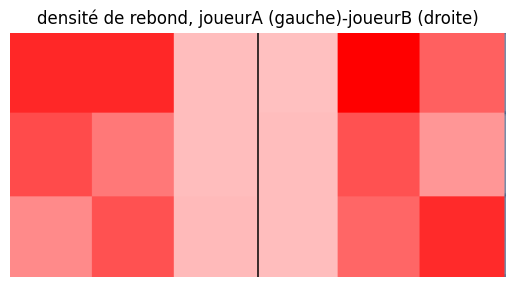

In [21]:
im_table_coloriee=im_table.copy()
liste=[0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5]
for i in range (len(zones)):
    for l in range(55):
        for L in range(56):
            im_table_coloriee.putpixel([L+54*liste[i],l+((i+2)%3) *53],(255,int(255/max(zones))*(max(zones)-zones[i]),int(255/max(zones))*(max(zones)-zones[i])))
for i in range (h):
    im_table_coloriee.putpixel([163,i],(0,0,0)) #trait noir pour le filet
            
plt.imshow(im_table_coloriee)
plt.axis('off')
plt.title("densité de rebond, joueurA (gauche)-joueurB (droite)")

Zones de rebond suite à un service

In [22]:
zones_reb1_jA=[]
zones_reb1_jB=[]
zones1=[0]*18

for i in range(1,len(annotations)):
    if annotations[i][26+C]=='1' and annotations[i][0]==joueurA:
        zones_reb1_jA.append(annotations[i][10])
    elif annotations[i][26+C]=='1' and annotations[i][0]==joueurB:
        zones_reb1_jB.append(annotations[i][10])
print('jA :', zones_reb1_jA)

for i in range(len(zones_reb1_jA)):
    if zones_reb1_jA[i]=='d1':
        zones1[11]+=1
    elif zones_reb1_jA[i]=='d2':
        zones1[14]+=1
    elif zones_reb1_jA[i]=='d3':
        zones1[17]+=1
    elif zones_reb1_jA[i]=='m1':
        zones1[10]+=1
    elif zones_reb1_jA[i]=='m2':
        zones1[13]+=1
    elif zones_reb1_jA[i]=='m3':
        zones1[16]+=1
    elif zones_reb1_jA[i]=='g1':
        zones1[9]+=1
    elif zones_reb1_jA[i]=='g2':
        zones1[12]+=1
    elif zones_reb1_jA[i]=='g3':
        zones1[15]+=1

for i in range(len(zones_reb1_jB)):
    if zones_reb1_jB[i]=='d1':
        zones1[6]+=1
    elif zones_reb1_jB[i]=='d2':
        zones1[3]+=1
    elif zones_reb1_jB[i]=='d3':
        zones1[0]+=1
    elif zones_reb1_jB[i]=='m1':
        zones1[7]+=1
    elif zones_reb1_jB[i]=='m2':
        zones1[4]+=1
    elif zones_reb1_jB[i]=='m3':
        zones1[1]+=1
    elif zones_reb1_jB[i]=='g1':
        zones1[8]+=1
    elif zones_reb1_jB[i]=='g2':
        zones1[5]+=1
    elif zones_reb1_jB[i]=='g3':
        zones1[2]+=1

print('nb de rebonds par zones suite au service :', zones1)

sum=0
for i in range(len(zones1)):
    sum+=zones1[i]
print(sum)

jA : ['m2', 'm2', 'm2', 'm2', 'g3', 'g3', 'm2', 'd2', 'm2', 'd2', 'm2', 'd2', 'd2', 'd2', 'd2', 'd2', 'd2', 'm2', 'g3', 'd2', 'm2', 'm2', 'm2', 'm2', 'm3', 'g2', 'd2', 'd2', 'm2', 'g2', 'g3', 'd2', 'm2', 'm2', 'd2', 'd2', 'd2', 'm2', 'm2', 'm2', 'm2', 'm2', 'g2', 'd2', 'm2', 'g2', 'm2', 'm2']
nb de rebonds par zones suite au service : [0, 6, 3, 17, 8, 8, 1, 0, 1, 0, 0, 0, 4, 23, 16, 4, 1, 0]
92


(-0.5, 326.5, 160.5, -0.5)

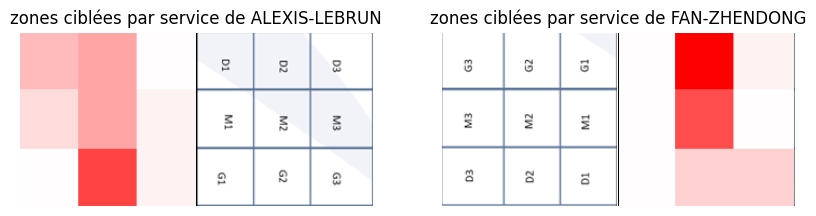

In [23]:
im_table_jA=im_table.copy()
im_table_jB=im_table.copy()

for i in range (9):
    for l in range(55):
        for L in range(56):
            im_table_jB.putpixel([L+54*liste[i],l+((i+2)%3) *53],(255,int(255/max(zones1))*(max(zones1)-zones1[i]),int(255/max(zones1))*(max(zones1)-zones1[i])))
for i in range (h):
    im_table_jB.putpixel([163,i],(0,0,0))

for i in range(9,18):
    for l in range(55):
        for L in range(56):
            im_table_jA.putpixel([L+54*liste[i],l+((i+2)%3) *53],(255,int(255/max(zones1))*(max(zones1)-zones1[i]),int(255/max(zones1))*(max(zones1)-zones1[i])))
for i in range (h):
    im_table_jA.putpixel([163,i],(0,0,0))
            

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(im_table_jB)
plt.title('zones ciblées par service de {}'.format(joueurB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im_table_jA)
plt.title('zones ciblées par service de {}'.format(joueurA))
plt.axis('off')

Lieu du dernier rebond (rebond de balle qui rapporte un point)

In [24]:
liste1=[]
liste2=[]
liste3=[]
compteur_gagne=0

for i in range(1,len(annotations)):
    liste1.append(annotations[i][58])
    liste2.append(annotations[i][52])
    if annotations[i][58]=='pt_gagne' and annotations[i][52] not in liste3:
        compteur_gagne+=1
        liste3.append(annotations[i][52])
#print(liste1)
#print(liste2)
print(liste3)
print('nb de pts qui ont été gagnés sans fautes :', compteur_gagne)

[]
nb de pts qui ont été gagnés sans fautes : 0


In [25]:
rebonds=[]
for i in range(1,len(annotations)-1):
    if annotations[i][52+C]!=annotations[i+1][52+C] and annotations[i][58+C]=='pt_gagne':
        rebonds.append([annotations[i][16], annotations[i][10],annotations[i][52]]) # joueur_frappe, zone_jeu, num_point
print(rebonds)

[['ALEXIS-LEBRUN', 'm1', '-1'], ['ALEXIS-LEBRUN', 'm3', '-1'], ['ALEXIS-LEBRUN', 'd2', '-1'], ['FAN-ZHENDONG', 'm3', '-1'], ['ALEXIS-LEBRUN', 'm3', '-1'], ['ALEXIS-LEBRUN', 'm2', '-1'], ['ALEXIS-LEBRUN', 'd3', '-1'], ['FAN-ZHENDONG', 'd3', '-1'], ['FAN-ZHENDONG', 'd2', '-1'], ['ALEXIS-LEBRUN', 'd2', '-1'], ['FAN-ZHENDONG', 'd3', '-1'], ['ALEXIS-LEBRUN', 'm3', '-1'], ['FAN-ZHENDONG', 'd2', '-1'], ['FAN-ZHENDONG', 'd3', '-1'], ['FAN-ZHENDONG', 'd2', '-1'], ['ALEXIS-LEBRUN', 'm3', '-1']]


In [26]:
zones_pt_gagne=[0]*18
for i in range(len(rebonds)):
    if rebonds[i][1]=='d1' and rebonds[i][0]==joueurB:
        zones_pt_gagne[6]+=1
    elif rebonds[i][1]=='d2' and rebonds[i][0]==joueurB:
        zones_pt_gagne[3]+=1
    elif rebonds[i][1]=='d3' and rebonds[i][0]==joueurB:
        zones_pt_gagne[0]+=1
    elif rebonds[i][1]=='m1' and rebonds[i][0]==joueurB:
        zones_pt_gagne[7]+=1
    elif rebonds[i][1]=='m2' and rebonds[i][0]==joueurB:
        zones_pt_gagne[4]+=1
    elif rebonds[i][1]=='m3' and rebonds[i][0]==joueurB:
        zones_pt_gagne[1]+=1
    elif rebonds[i][1]=='g1' and rebonds[i][0]==joueurB:
        zones_pt_gagne[8]+=1
    elif rebonds[i][1]=='g2' and rebonds[i][0]==joueurB:
        zones_pt_gagne[5]+=1
    elif rebonds[i][1]=='g3' and rebonds[i][0]==joueurB:
        zones_pt_gagne[2]+=1
    elif rebonds[i][1]=='d1' and rebonds[i][0]==joueurA:
        zones_pt_gagne[11]+=1
    elif rebonds[i][1]=='d2' and rebonds[i][0]==joueurA:
        zones_pt_gagne[14]+=1
    elif rebonds[i][1]=='d3' and rebonds[i][0]==joueurA:
        zones_pt_gagne[17]+=1
    elif rebonds[i][1]=='m1' and rebonds[i][0]==joueurA:
        zones_pt_gagne[10]+=1
    elif rebonds[i][1]=='m2' and rebonds[i][0]==joueurA:
        zones_pt_gagne[13]+=1
    elif rebonds[i][1]=='m3' and rebonds[i][0]==joueurA:
        zones_pt_gagne[16]+=1
    elif rebonds[i][1]=='g1' and rebonds[i][0]==joueurA:
        zones_pt_gagne[9]+=1
    elif rebonds[i][1]=='g2' and rebonds[i][0]==joueurA:
        zones_pt_gagne[12]+=1
    elif rebonds[i][1]=='g3' and rebonds[i][0]==joueurA:
        zones_pt_gagne[15]+=1

sum=0
for i in range(len(zones_pt_gagne)):
    sum+=zones_pt_gagne[i] 

print('nb de rebonds menant à pt gagnant par zone:', zones_pt_gagne)
print('nb de rebonds menant à pt gagnant :',sum)

nb de rebonds menant à pt gagnant par zone: [1, 4, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 1, 3]
nb de rebonds menant à pt gagnant : 16


(-0.5, 326.5, 160.5, -0.5)

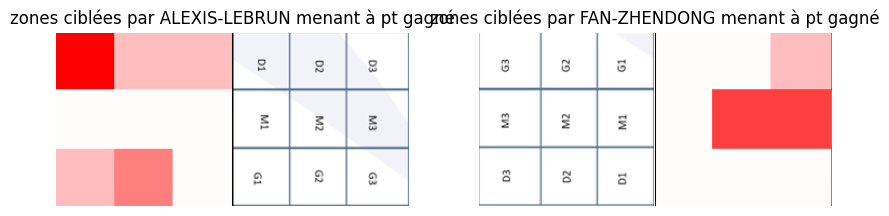

In [28]:
im_table_jA_gagne=im_table.copy()
im_table_jB_gagne=im_table.copy()

for i in range (9):
    for l in range(55):
        for L in range(56):
            im_table_jB_gagne.putpixel([L+54*liste[i],l+((i+2)%3) *53],(255,63*(4-zones_pt_gagne[i]),63*(4-zones_pt_gagne[i])))
for i in range (h):
    im_table_jB_gagne.putpixel([163,i],(0,0,0))

for i in range(9,18):
    for l in range(55):
        for L in range(56):
            im_table_jA_gagne.putpixel([L+54*liste[i],l+((i+2)%3) *53],(255,int(255/max(zones_pt_gagne))*(max(zones_pt_gagne)-zones_pt_gagne[i]),int(255/max(zones_pt_gagne))*(max(zones_pt_gagne)-zones_pt_gagne[i])))
for i in range (h):
    im_table_jA_gagne.putpixel([163,i],(0,0,0))
            

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(im_table_jB_gagne)
plt.title('zones ciblées par {} menant à pt gagné'.format(joueurB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im_table_jA_gagne)
plt.title('zones ciblées par {} menant à pt gagné'.format(joueurA))
plt.axis('off')

Position joueur-balle à chaque coup

In [29]:
im_table_env=Image.open("environnement_demie_table.png").convert('RGB')
W_im_env, h_im_env=im_table_env.size

800 400


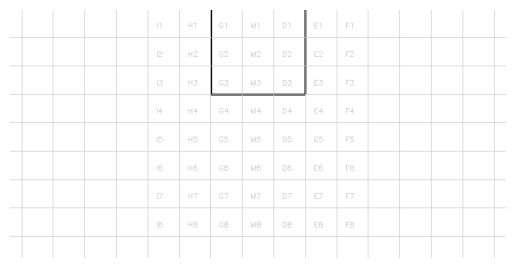

In [30]:
plt.imshow(im_table_env)
plt.axis('off')
print(W_im_env,h_im_env)

In [31]:
#extraction positions joueur + balle + info si le joueur est en haut ou en bas (change à chaque set)
positions_1=[]
positions_2=[]
for i in range(len(annotations)):
    if annotations[i][62+C]=='haut' and annotations[i][16]==joueurA: # l17 : joueur_frappe
        positions_1.append([float(annotations[i][18]),-float(annotations[i][19]),float(annotations[i][34+C]),-float(annotations[i][35+C]),'haut', annotations[i][26+C]]) #x_balle, y_balle, x_joueur, y_joueur, cote_joueur, num_coup
    elif annotations[i][62+C]=='bas' and annotations[i][16]==joueurA:
        positions_1.append([float(annotations[i][18]),-float(annotations[i][19]),float(annotations[i][34+C]),-float(annotations[i][35+C]),'bas', annotations[i][26+C]])
    elif annotations[i][63+C]=='haut' and annotations[i][16]==joueurB:
        positions_2.append([float(annotations[i][18]),-float(annotations[i][19]),float(annotations[i][37+C]),-float(annotations[i][38+C]),'haut', annotations[i][26+C]])
    elif annotations[i][63+C]=='bas' and annotations[i][16]==joueurB:
        positions_2.append([float(annotations[i][18]),-float(annotations[i][19]),float(annotations[i][37+C]),-float(annotations[i][38+C]),'bas', annotations[i][26+C]])

In [32]:
size=10
R=25

In [36]:
os.path.join('{}'.format(match),'pos_b_j_{}'.format(match))

'C:/Users/ReViVD/Desktop/dataroom/pipeline-tt\\2024_ChMondeEquipe_Busan\\FAN-ZHENDONG_vs_ALEXIS-LEBRUN\\FAN-ZHENDONG_vs_ALEXIS-LEBRUN\\pos_b_j_C:/Users/ReViVD/Desktop/dataroom/pipeline-tt\\2024_ChMondeEquipe_Busan\\FAN-ZHENDONG_vs_ALEXIS-LEBRUN\\FAN-ZHENDONG_vs_ALEXIS-LEBRUN'

In [39]:
# Positions au moment de la frappe

os.makedirs(os.path.join('{}'.format(match),'pos_b_j_{}'.format(os.path.split(match)[1])), exist_ok='True')

for i in range(len(positions_1)):
    im_table_env_jA=im_table_env.copy()
    draw = ImageDraw.Draw(im_table_env_jA)
    if positions_1[i][4]=='bas':
        x_balle=positions_1[i][0]+W_im_env/2
        y_balle=-positions_1[i][1]
        x_joueur=positions_1[i][2]+W_im_env/2
        y_joueur=-positions_1[i][3]
    elif positions_1[i][4]=='haut':
        x_balle=-positions_1[i][0]+W_im_env/2
        y_balle=positions_1[i][1]
        x_joueur=-positions_1[i][2]+W_im_env/2
        y_joueur=positions_1[i][3]
    draw.ellipse((x_balle - size, y_balle - size, x_balle + size, y_balle + size), fill="blue")
    draw.ellipse((x_joueur - size, y_joueur - size, x_joueur + size, y_joueur + size), fill="red")
    im_table_env_jA.save(os.path.join('{}'.format(match),'pos_b_j_{}'.format(os.path.split(match)[1]),'image_jA_{}.jpg'.format(i)))

for i in range(len(positions_2)):
    im_table_env_jB=im_table_env.copy()
    draw = ImageDraw.Draw(im_table_env_jB)
    if positions_2[i][4]=='haut':
        x_balle=-positions_2[i][0]+W_im_env/2
        y_balle=positions_2[i][1]
        x_joueur=-positions_2[i][2]+W_im_env/2
        y_joueur=positions_2[i][3]
    elif positions_2[i][4]=='bas':
        x_balle=positions_2[i][0]+W_im_env/2
        y_balle=-positions_2[i][1]
        x_joueur=positions_2[i][2]+W_im_env/2
        y_joueur=-positions_2[i][3]
    draw.ellipse((x_balle - size, y_balle - size, x_balle + size, y_balle + size), fill="blue")
    draw.ellipse((x_joueur - size, y_joueur - size, x_joueur + size, y_joueur + size), fill="red")
    im_table_env_jB.save(os.path.join('{}'.format(match),'pos_b_j_{}'.format(os.path.split(match)[1]),'image_jB_{}.jpg'.format(i)))

Carte de densité position joueur au moment du coup

Text(0.5, 1.0, 'densité de présence de FAN-ZHENDONG')

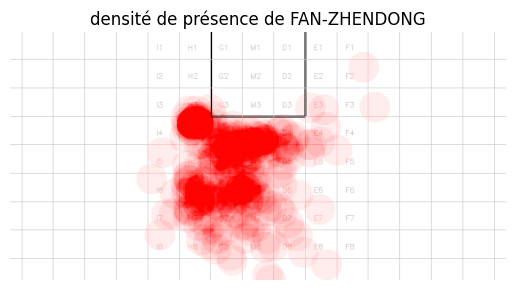

In [40]:
im_table_env_densite_jA=im_table_env.copy()
px_table_env_jA=im_table_env_densite_jA.load()
g=255
b=255

for i in range(len(positions_1)):
    if positions_1[i][4]=='bas':
        x_jA=positions_1[i][2]+W_im_env/2
        y_jA=-positions_1[i][3]     
    elif positions_1[i][4]=='haut':
        x_jA=-positions_1[i][2]+W_im_env/2
        y_jA=positions_1[i][3]
    
    for l in range(2*R):
        for L in range(2*R):
            if (L-R)**2+(l-R)**2<R**2:
                if x_jA+L-R<W_im_env and y_jA+l-R<h_im_env and x_jA+L-R>0 and y_jA+l-R>0:
                    g=int(px_table_env_jA[x_jA+L-R,y_jA+l-R][1]-18)
                    b=int(px_table_env_jA[x_jA+L-R,y_jA+l-R][2]-18)
                    if g>0 and b>0:
                        im_table_env_densite_jA.putpixel([int(x_jA+L-R),int(y_jA+l-R)],(int(255),g,b))
                        px_table_env_jA=im_table_env_densite_jA.load()

plt.imshow(im_table_env_densite_jA)
plt.axis('off')
plt.title('densité de présence de {}'.format(joueurA))

(-0.5, 799.5, 399.5, -0.5)

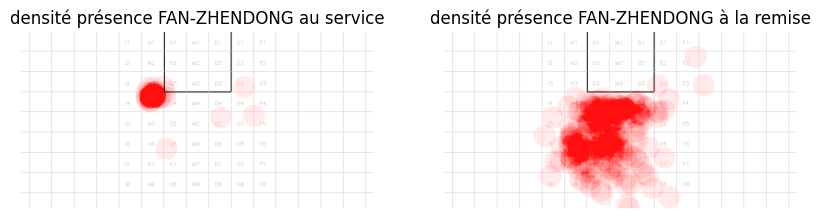

In [41]:
# pour avoir la même carte, en différanciant service et remise

im_table_env_densite_jA_service=im_table_env.copy()
im_table_env_densite_jA_remise=im_table_env.copy()
px_table_env_jA_service=im_table_env_densite_jA_service.load()
px_table_env_jA_remise=im_table_env_densite_jA_remise.load()

for i in range(len(positions_1)):
    if positions_1[i][5]=='1':
        g=255
        b=255
        if positions_1[i][4]=='bas':
            x_jA=positions_1[i][2]+W_im_env/2
            y_jA=-positions_1[i][3]
        elif positions_1[i][4]=='haut':
            x_jA=-positions_1[i][2]+W_im_env/2
            y_jA=positions_1[i][3]
        for l in range(2*R):
            for L in range(2*R):
                if (L-R)**2+(l-R)**2<R**2:
                    if x_jA+L-R<W_im_env and y_jA+l-R<h_im_env:
                        g=int(px_table_env_jA_service[x_jA+L-R,y_jA+l-R][1]-20)
                        b=int(px_table_env_jA_service[x_jA+L-R,y_jA+l-R][2]-20)
                        if g>0 and b>0:
                            im_table_env_densite_jA_service.putpixel([int(x_jA+L-R),int(y_jA+l-R)],(255,g,b))
                            px_table_env_jA_service=im_table_env_densite_jA_service.load()
    if positions_1[i][5]!='1':
        g=255
        b=255
        if positions_1[i][4]=='bas':
            x_jA=positions_1[i][2]+W_im_env/2
            y_jA=-positions_1[i][3]  
        elif positions_1[i][4]=='haut':
            x_jA=-positions_1[i][2]+W_im_env/2
            y_jA=positions_1[i][3]
        for l in range(2*R):
            for L in range(2*R):
                if (L-R)**2+(l-R)**2<R**2:
                    if x_jA+L-R<W_im_env and y_jA+l-R<h_im_env and x_jA+L-R>0 and y_jA+l-R>0:
                        g=int(px_table_env_jA_remise[x_jA+L-R,y_jA+l-R][1]-20)
                        b=int(px_table_env_jA_remise[x_jA+L-R,y_jA+l-R][2]-20)
                        if g>0 and b>0:
                            im_table_env_densite_jA_remise.putpixel([int(x_jA+L-R),int(y_jA+l-R)],(255,g,b))
                            px_table_env_jA_remise=im_table_env_densite_jA_remise.load()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(im_table_env_densite_jA_service)
plt.title('densité présence {} au service'.format(joueurA))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im_table_env_densite_jA_remise)
plt.title('densité présence {} à la remise'.format(joueurA))
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

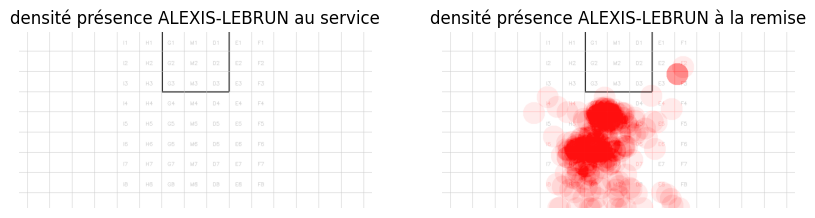

In [ ]:
im_table_env_densite_jB_service=im_table_env.copy()
im_table_env_densite_jB_remise=im_table_env.copy()
px_table_env_jB_service=im_table_env_densite_jB_service.load()
px_table_env_jB_remise=im_table_env_densite_jB_remise.load()

for i in range(len(positions_2)):
    if positions_2[i][5]=='1':
        g=255
        b=255
        if positions_2[i][4]=='haut':
            x_jB=-positions_2[i][2]+W_im_env/2
            y_jB=positions_2[i][3]  
        elif positions_2[i][4]=='bas':
            x_jB=positions_2[i][2]+W_im_env/2
            y_jB=-positions_2[i][3]
        for l in range(2*R):
            for L in range(2*R):
                if (L-R)**2+(l-R)**2<R**2:
                    if x_jB+L-R<W_im_env and y_jB+l-R<h_im_env and x_jA+L-R>0 and y_jA+l-R>0:
                        g=int(px_table_env_jB_service[x_jB+L-R,y_jB+l-R][1]-20)
                        b=int(px_table_env_jB_service[x_jB+L-R,y_jB+l-R][2]-20)
                        if g>0 and b>0:
                            im_table_env_densite_jB_service.putpixel([int(x_jB+L-R),int(y_jB+l-R)],(255,g,b))
                            px_table_env_jB_service=im_table_env_densite_jB_service.load()
    if positions_2[i][5]!='1':
        g=255
        b=255
        if positions_2[i][4]=='haut':
            x_jB=-positions_2[i][2]+W_im_env/2
            y_jB=positions_2[i][3] 
        elif positions_2[i][4]=='bas':
            x_jB=positions_2[i][2]+W_im_env/2
            y_jB=-positions_2[i][3]
        for l in range(2*R):
            for L in range(2*R):
                if (L-R)**2+(l-R)**2<R**2:
                    if x_jB+L-R<W_im_env and y_jB+l-R<h_im_env and x_jA+L-R>0 and y_jA+l-R>0:
                        g=int(px_table_env_jB_remise[x_jB+L-R,y_jB+l-R][1]-20)
                        b=int(px_table_env_jB_remise[x_jB+L-R,y_jB+l-R][2]-20)
                        if g>0 and b>0:
                            im_table_env_densite_jB_remise.putpixel([int(x_jB+L-R),int(y_jB+l-R)],(255,g,b))
                            px_table_env_jB_remise=im_table_env_densite_jB_remise.load()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(im_table_env_densite_jB_service)
plt.title('densité présence {} au service'.format(joueurB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im_table_env_densite_jB_remise)
plt.title('densité présence {} à la remise'.format(joueurB))
plt.axis('off')

In [44]:
im_table_env_densite_jA_service.save(os.path.join('{}'.format(match),'densite_presence_jA_service.png'))
im_table_env_densite_jA_remise.save(os.path.join('{}'.format(match),'densite_presence_jA_remise.png'))
im_table_env_densite_jB_service.save(os.path.join('{}'.format(match),'densite_presence_jB_service.png'))
im_table_env_densite_jB_remise.save(os.path.join('{}'.format(match),'densite_presence_jB_remise.png'))

Calcul de la position moyenne des joueurs

40.42747213269368 213.7912596785977


Text(0.5, 1.0, 'position moyenne FAN-ZHENDONG (pt noir)')

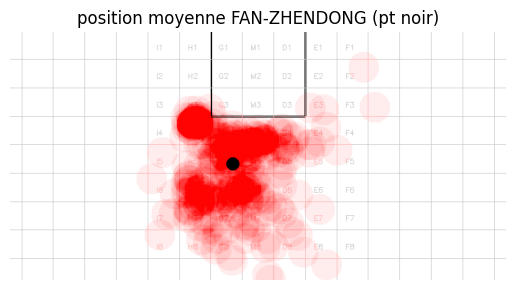

In [45]:
im_densite_jA=im_table_env_densite_jA.copy()
position_1=[]
for i in range(len(positions_1)):
    if positions_1[i][4]=='haut':
        position_1.append([positions_1[i][2],positions_1[i][3]])
    elif positions_1[i][4]=='bas':
        position_1.append([-positions_1[i][2],-positions_1[i][3]])
pos_moy_x=0
pos_moy_y=0
for i in range(len(position_1)):
    pos_moy_x+=position_1[i][0]
    pos_moy_y+=position_1[i][1]
pos_moy_x=pos_moy_x/len(position_1)
pos_moy_y=pos_moy_y/len(position_1)
print(pos_moy_x,pos_moy_y)

draw=ImageDraw.Draw(im_densite_jA)
size=10
x_moy=-pos_moy_x+W_im_env/2
y_moy=pos_moy_y
draw.ellipse((x_moy-size, y_moy-size, x_moy+size, y_moy+size), fill='black')
plt.imshow(im_densite_jA)
plt.axis('off')
plt.title('position moyenne {} (pt noir)'.format(joueurA))

70.48758597995923 148.17228267503822


Text(0.5, 1.0, 'position moyenne ALEXIS-LEBRUN au service (pt noir)')

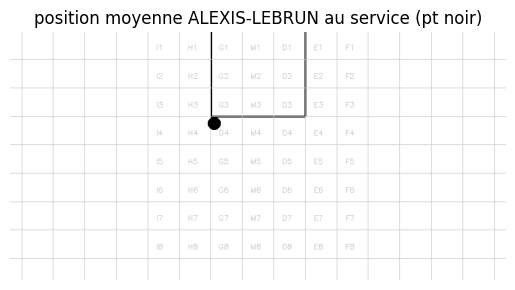

In [46]:
im_densite_jB_service=im_table_env_densite_jB_service.copy()
position_2=[]
for i in range(len(positions_2)):
    if positions_2[i][4]=='haut' and positions_2[i][5]=='1':
        position_2.append([positions_2[i][2],positions_2[i][3]])
    elif positions_2[i][4]=='bas' and positions_2[i][5]=='1':
        position_2.append([-positions_2[i][2],-positions_2[i][3]])
pos_moy_x=0
pos_moy_y=0
for i in range(len(position_2)):
    pos_moy_x+=position_2[i][0]
    pos_moy_y+=position_2[i][1]
pos_moy_x=pos_moy_x/len(position_2)
pos_moy_y=pos_moy_y/len(position_2)
print(pos_moy_x,pos_moy_y)

draw=ImageDraw.Draw(im_densite_jB_service)
x_moy=-pos_moy_x+W_im_env/2
y_moy=pos_moy_y
draw.ellipse((x_moy-size, y_moy-size, x_moy+size, y_moy+size), fill='black')
plt.imshow(im_densite_jB_service)
plt.axis('off')
plt.title('position moyenne {} au service (pt noir)'.format(joueurB))

5.8245086669921875 75.3372106122541


Text(0.5, 1.0, 'position moyenne ALEXIS-LEBRUN à la remise (pt noir)')

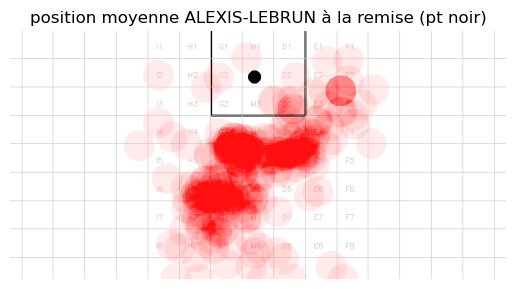

In [60]:
im_densite_jB_remise=im_table_env_densite_jB_remise.copy()
position_2=[]
for i in range(len(positions_2)):
    if positions_2[i][4]=='haut' and positions_2[i][5]!='1':
        position_2.append([positions_2[i][2],positions_2[i][3]])
    elif positions_2[i][4]=='bas' and positions_2[i][5]!='1':
        position_2.append([-positions_2[i][2],-positions_2[i][3]])
pos_moy_x=0
pos_moy_y=0
for i in range(len(position_2)):
    pos_moy_x+=position_2[i][0]
    pos_moy_y+=position_2[i][1]
pos_moy_x=pos_moy_x/len(position_2)
pos_moy_y=pos_moy_y/len(position_2)
print(pos_moy_x,pos_moy_y)

draw=ImageDraw.Draw(im_densite_jB_remise)
x_moy=-pos_moy_x+W_im_env/2
y_moy=pos_moy_y
draw.ellipse((x_moy-size, y_moy-size, x_moy+size, y_moy+size), fill='black')
plt.imshow(im_densite_jB_remise)
plt.axis('off')
plt.title('position moyenne {} à la remise (pt noir)'.format(joueurB))

Position joueur et rebond balle pour coup gagnant

In [61]:
coord_rebond_gagnant=[]
for i in range(len(annotations)):
    if annotations[i][11]=='pt_gagne': # l12 : faute (filet, out ou pt_gagne)
        if annotations[i][17]==joueurA: # l18 : joueur_sur
            coord_rebond_gagnant.append([float(annotations[i][13]),-float(annotations[i][14]),float(annotations[i][34+C]), -float(annotations[i][35+C]), annotations[i][17],annotations[i][62+C], annotations[i][52+C]]) #pos balle x reb, pos balle y reb, pos joueur x, pos joueur y, joueur, côté joueur, num_point
        else :
            coord_rebond_gagnant.append([float(annotations[i][13]),-float(annotations[i][14]),float(annotations[i][37+C]), -float(annotations[i][38+C]), annotations[i][17],annotations[i][63+C], annotations[i][52+C]])

print(coord_rebond_gagnant[0])
print(len(coord_rebond_gagnant))

[20.39727668762207, 27.176443354288736, 37.622314453125, -233.183349609375, 'FAN-ZHENDONG', 'haut', '1']
16


In [62]:
os.makedirs(os.path.join('match_{}'.format(match),'rebond_gagnant_{}'.format(match)), exist_ok='True')

for i in range(len(coord_rebond_gagnant)):
    im_rebond_gagnant=im_table_env.copy()
    draw = ImageDraw.Draw(im_rebond_gagnant)
    if coord_rebond_gagnant[i][5]=='bas':
        x_balle=coord_rebond_gagnant[i][0]+W_im_env/2
        y_balle=-coord_rebond_gagnant[i][1]
        x_joueur=coord_rebond_gagnant[i][2]+W_im_env/2
        y_joueur=-coord_rebond_gagnant[i][3]
    elif coord_rebond_gagnant[i][5]=='haut':
        x_balle=-coord_rebond_gagnant[i][0]+W_im_env/2
        y_balle=coord_rebond_gagnant[i][1]
        x_joueur=-coord_rebond_gagnant[i][2]+W_im_env/2
        y_joueur=coord_rebond_gagnant[i][3]
    draw.ellipse((x_balle - size, y_balle - size, x_balle + size, y_balle + size), (0,0,255))
    if coord_rebond_gagnant[i][4]==joueurA:
        draw.ellipse((x_joueur - size, y_joueur - size, x_joueur + size, y_joueur + size), (120,67,21))
    elif coord_rebond_gagnant[i][4]==joueurB :
        draw.ellipse((x_joueur - size, y_joueur - size, x_joueur + size, y_joueur + size), (255,252,36))
    im_rebond_gagnant.save(os.path.join('match_{}'.format(match),'rebond_gagnant_{}'.format(match),'rebond_gagnant_{}.jpg'.format(i)))

la visualisation n'est pas dingue ; c'est plus pertinent et compréhensible si on avait les vecteurs de déplacement des joueurs et de la balle. c'est ce que j'essaye de faire par la suite.

Position joueur balle coup gagnant avec vecteur

In [64]:
coord_joueur_balle_vecteur=[] #pour problème d'après

for i in range(2,len(annotations)) :
    if annotations[i][11]=='pt_gagne':
        vecteur=[float(annotations[i][13])-float(annotations[i-1][13]),-float(annotations[i][14])+float(annotations[i-1][14])] #vecteur de la trajectoire de la balle
        coord_queue_fleche=[float(annotations[i][13]), -float(annotations[i][14])] # = coordonnées rebond de la balle au coup i
        coord_tete_fleche=[float(annotations[i][13])+vecteur[0]/3, -float(annotations[i][14])+vecteur[1]/3] # = coordonnées rebond de la balle au coup i + coordonnées vecteur/3 (coefficient arbitraire pour éviter que la fléche ne soit trop longue mais qu'elle rende compte qdmm des vitesses)

        if annotations[i][17]==joueurA:
            vecteur2=[float(annotations[i][34+C])-float(annotations[i-1][34+C]),-float(annotations[i][35+C])+float(annotations[i-1][35+C])] #vecteur de la trajectoire du joueur
            coord_queue_fleche2=[float(annotations[i][34+C]), -float(annotations[i][35+C])]
            coord_tete_fleche2=[float(annotations[i][34+C])+vecteur2[0]/3, -float(annotations[i][35+C])+vecteur2[1]/3]
        elif annotations[i][17]==joueurB:
            vecteur2=[float(annotations[i][37+C])-float(annotations[i-1][37+C]),-float(annotations[i][38+C])+float(annotations[i-1][38+C])]
            coord_queue_fleche2=[float(annotations[i][37+C]), -float(annotations[i][38+C])]
            coord_tete_fleche2=[float(annotations[i][37+C])+vecteur2[0]/3, -float(annotations[i][38+C])+vecteur2[1]/3]

        for j in range(len(coord_rebond_gagnant)):
            if float(annotations[i][13])==coord_rebond_gagnant[j][0]:
                index=j
                if coord_rebond_gagnant[j][5]=='bas':
                    coord_queue_fleche[0]=coord_queue_fleche[0]+W_im_env/2
                    coord_queue_fleche[1]=-coord_queue_fleche[1]
                    coord_tete_fleche[0]=coord_tete_fleche[0]+W_im_env/2
                    coord_tete_fleche[1]=-coord_tete_fleche[1]
                    coord_queue_fleche2[0]=coord_queue_fleche2[0]+W_im_env/2
                    coord_queue_fleche2[1]=-coord_queue_fleche2[1]
                    coord_tete_fleche2[0]=coord_tete_fleche2[0]+W_im_env/2
                    coord_tete_fleche2[1]=-coord_tete_fleche2[1]
                elif coord_rebond_gagnant[j][5]=='haut':
                    coord_queue_fleche[0]=-coord_queue_fleche[0]+W_im_env/2
                    coord_queue_fleche[1]=coord_queue_fleche[1]
                    coord_tete_fleche[0]=-coord_tete_fleche[0]+W_im_env/2
                    coord_tete_fleche[1]=coord_tete_fleche[1]
                    coord_queue_fleche2[0]=-coord_queue_fleche2[0]+W_im_env/2
                    coord_queue_fleche2[1]=coord_queue_fleche2[1]
                    coord_tete_fleche2[0]=-coord_tete_fleche2[0]+W_im_env/2
                    coord_tete_fleche2[1]=coord_tete_fleche2[1]

        #pour problème suivant :
        coord_joueur_balle_vecteur.append([coord_queue_fleche2[0],coord_queue_fleche2[1],coord_queue_fleche[0], coord_queue_fleche[1], coord_tete_fleche[0]-coord_queue_fleche[0], coord_tete_fleche[1]-coord_queue_fleche[1]])

        image=cv2.imread(os.path.join('match_{}'.format(match),'rebond_gagnant_{}'.format(match), 'rebond_gagnant_{}.jpg'.format(index)))
        image=cv2.arrowedLine(image, (int(coord_queue_fleche[0]),int(coord_queue_fleche[1])), (int(coord_tete_fleche[0]), int(coord_tete_fleche[1])), color=(239,136,190), thickness=2)
        image=cv2.arrowedLine(image, (int(coord_queue_fleche2[0]),int(coord_queue_fleche2[1])), (int(coord_tete_fleche2[0]), int(coord_tete_fleche2[1])), color=(38,191,239), thickness=2)
        cv2.imwrite(os.path.join('match_{}'.format(match), 'rebond_gagnant_{}'.format(match), 'rebond_gagnant_{}.jpg'.format(index)), image)

Calcul distance minimale entre la position du joueur lorsque la balle rebondit et la trajectoire de la balle (but : essayer de trouver la proba d'atteindre la balle en fonction des positions du joueur et du rebond)

In [65]:
distances_pt=[]
distances_pas_pt=[]
for i in range(1,len(annotations)):
    if annotations[i][8]=='': #l9 : type_service
        if annotations[i][17]==joueurA and annotations[i][11]!='out' and annotations[i][11]!='filet': # l18 : joueur_sur
            BJ=[float(annotations[i][34+C])-float(annotations[i][13]), -float(annotations[i][35+C])+float(annotations[i][14])]
            v=[float(annotations[i][13])-float(annotations[i-1][13]), -float(annotations[i][14])+float(annotations[i-1][14])]
            norm_v=np.linalg.norm(v)
            norm_BA=np.dot(BJ,v)/norm_v
            v_norm=[v[j]/norm_v for j in range(2)]
            BA=[norm_BA*v_norm[j] for j in range(2)]
            A=[float(annotations[i][13])+BA[0], -float(annotations[i][14])+BA[1]]
            d=np.linalg.norm([A[0]-float(annotations[i][34+C]), A[1]+float(annotations[i][35+C])])
            if annotations[i][11]=='': # l12 : faute
                distances_pas_pt.append((int(d), int(norm_v)))
            elif annotations[i][11]=='pt_gagne':
                distances_pt.append((int(d), int(norm_v)))
        elif annotations[i][17]==joueurB and annotations[i][11]!='out' and annotations[i][11]!='filet':
            BJ=[float(annotations[i][37+C])-float(annotations[i][13]), -float(annotations[i][38+C])+float(annotations[i][14])]
            v=[float(annotations[i][13])-float(annotations[i-1][13]), -float(annotations[i][14])+float(annotations[i-1][14])]
            norm_v=np.linalg.norm(v)
            norm_BA=np.dot(BJ,v)/norm_v
            v_norm=[v[j]/norm_v for j in range(2)]
            BA=[norm_BA*v_norm[j] for j in range(2)]
            A=[float(annotations[i][13])+BA[0], float(annotations[i][14])+BA[1]]
            d=np.linalg.norm([A[0]-float(annotations[i][34+C]), A[1]+float(annotations[i][35+C])])
            if annotations[i][11]=='': # l12 : faute
                distances_pas_pt.append((int(d), int(norm_v)))
            elif annotations[i][11]=='pt_gagne':
                distances_pt.append((int(d), int(norm_v)))

In [66]:
abscisses_pt=[distances_pt[i][0] for i in range(len(distances_pt))]
abscisses_pas_pt=[distances_pas_pt[i][0] for i in range(len(distances_pas_pt))]
ordonnees_pt=[distances_pt[i][1] for i in range(len(distances_pt))]
ordonnees_pas_pt=[distances_pas_pt[i][1] for i in range(len(distances_pas_pt))]

Text(0.5, 1.0, "Lorsque la balle n'est pas renvoyée par le receveur")

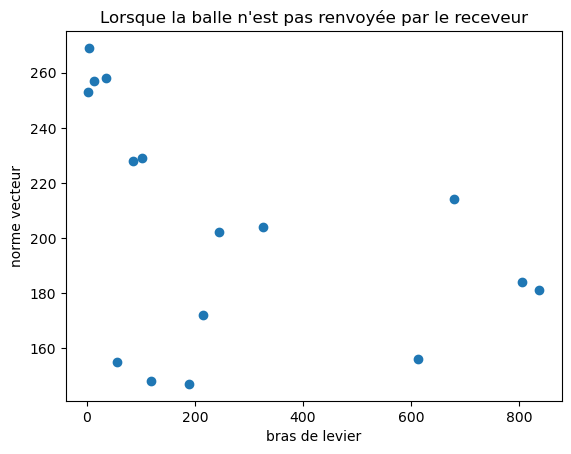

In [67]:
plt.scatter(abscisses_pt,ordonnees_pt)
plt.xlabel('bras de levier')
plt.ylabel('norme vecteur')
plt.title("Lorsque la balle n'est pas renvoyée par le receveur")

Text(0.5, 1.0, 'Lorsque la balle est renvoyée par le receveur')

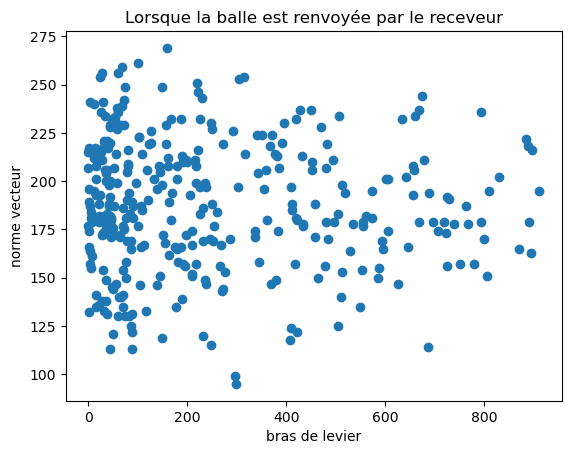

In [68]:
plt.scatter(abscisses_pas_pt,ordonnees_pas_pt)
plt.xlabel('bras de levier')
plt.ylabel('norme vecteur')
plt.title("Lorsque la balle est renvoyée par le receveur")